This notebook shows how to plot and get the nodes of a convex polyhedral function.

# One dimensional polyhedral function

Consider the polyhedral function
$$ f(x) = \max(-4x - 1, 2x - 1, -x/4, x/2) $$
in the interval $x \in [-1, 1]$.

As the function is convex (as it is the maximum of linear functions), its epigraph is convex. It is defined as the set of $x, y$ satisfying
\begin{align*}
  -1 & \le x\\
  x & \le 1\\
  -4x - 1 & \le y\\
  2x - 1 & \le y\\
  -x/4 & \le y\\
  x/2 & \le y
\end{align*}
We can create this H-representation in Polyhedra as follows:

In [1]:
using Polyhedra
h = HalfSpace([-1, 0], 1) ∩ HalfSpace([1, 0], 1) ∩ HalfSpace([-4, -1], 1) ∩ HalfSpace([2, -1], 1) ∩
    HalfSpace([-1/4, -1], 0) ∩ HalfSpace([1/2, -1], 0)

H-representation Polyhedra.Intersection{Float64,Array{Float64,1},Int64}:
6-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-4.0, -1.0], 1.0)
 HalfSpace([2.0, -1.0], 1.0)
 HalfSpace([-0.25, -1.0], 0.0)
 HalfSpace([0.5, -1.0], 0.0)

We now transform it to a polyhedron using [CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl), the library that is chosen to compute the V-representation.

In [2]:
using CDDLib
p = polyhedron(h, CDDLib.Library())

Polyhedron CDDLib.Polyhedron{Float64}:
6-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-4.0, -1.0], 1.0)
 HalfSpace([2.0, -1.0], 1.0)
 HalfSpace([-0.25, -1.0], 0.0)
 HalfSpace([0.5, -1.0], 0.0)

Note that creating the polyhedron does not trigger the computation of the V-representation by itself.
This is done when the V-representation is queried, e.g. by `vrep`.
We can see that 5 nodes of the polyhedral function with the ray $(0, 1)$ which is expected for an epigraph.

In [3]:
vrep(p)

V-representation CDDGeneratorMatrix{Float64,Float64}:
5-element iterator of Array{Float64,1}:
 [1.0, 1.0]
 [0.0, 0.0]
 [0.666667, 0.333333]
 [-0.266667, 0.0666667]
 [-1.0, 3.0],
1-element iterator of Ray{Float64,Array{Float64,1}}:
 Ray([-1.77636e-16, 1.0])

We see now that the V-representation is known by the polyhedron. Now both the H- and V-representation are available.

In [4]:
p

Polyhedron CDDLib.Polyhedron{Float64}:
6-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-4.0, -1.0], 1.0)
 HalfSpace([2.0, -1.0], 1.0)
 HalfSpace([-0.25, -1.0], 0.0)
 HalfSpace([0.5, -1.0], 0.0):
5-element iterator of Array{Float64,1}:
 [1.0, 1.0]
 [0.0, 0.0]
 [0.666667, 0.333333]
 [-0.266667, 0.0666667]
 [-1.0, 3.0],
1-element iterator of Ray{Float64,Array{Float64,1}}:
 Ray([-1.77636e-16, 1.0])

We can plot the epigraph as follows. Note that rays are not supported for 2D plotting, the polyhedron needs to be bounded so we add the halfspace $y \le 4$.

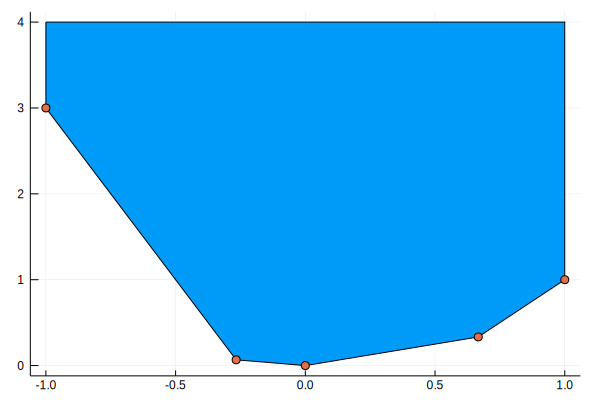

In [5]:
using Plots
plot(p ∩ HalfSpace([0, 1], 4))
scatter!([x[1] for x in points(p)], [x[2] for x in points(p)])

# Two dimensional polyhedral function

Consider the polyhedral function
$$ f(x) = \max(-4x - 2y - 1, 2x - y - 1, -x/4 + y/2, x/2 + y) $$
in the interval $(x, y) \in [-1, 1]^2$.

As the function is convex (as it is the maximum of linear functions), its epigraph is convex. It is defined as the set of $x, y, z$ satisfying
\begin{align*}
  -1 & \le x\\
  x & \le 1\\
  -1 & \le y\\
  y & \le 1\\
  -4x - 2y - 1 & \le z\\
  2x - y - 1 & \le z\\
  -x/4 + y/2 & \le z\\
  x/2 + y & \le z
\end{align*}
We can create this H-representation in Polyhedra as follows:

In [6]:
using Polyhedra
h = HalfSpace([-1, 0, 0], 1) ∩ HalfSpace([1, 0, 0], 1) ∩
    HalfSpace([0, -1, 0], 1) ∩ HalfSpace([0, 1, 0], 1) ∩
    HalfSpace([-4, -2, -1], 1) ∩ HalfSpace([2, -1, -1], 1) ∩
    HalfSpace([-1/4, 1/2, -1], 0) ∩ HalfSpace([1/2, 1, -1], 0)

H-representation Polyhedra.Intersection{Float64,Array{Float64,1},Int64}:
8-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([-1.0, 0.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0, 0.0], 1.0)
 HalfSpace([0.0, -1.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0, 0.0], 1.0)
 HalfSpace([-4.0, -2.0, -1.0], 1.0)
 HalfSpace([2.0, -1.0, -1.0], 1.0)
 HalfSpace([-0.25, 0.5, -1.0], 0.0)
 HalfSpace([0.5, 1.0, -1.0], 0.0)

We create the polyhedron the same way as for 1-dimensional polyhedral functions.

In [7]:
using CDDLib
p = polyhedron(h, CDDLib.Library())

Polyhedron CDDLib.Polyhedron{Float64}:
8-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([-1.0, 0.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0, 0.0], 1.0)
 HalfSpace([0.0, -1.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0, 0.0], 1.0)
 HalfSpace([-4.0, -2.0, -1.0], 1.0)
 HalfSpace([2.0, -1.0, -1.0], 1.0)
 HalfSpace([-0.25, 0.5, -1.0], 0.0)
 HalfSpace([0.5, 1.0, -1.0], 0.0)

We obtain the 10 nodes as follows along with the $(0, 0, 1)$ ray that is expected as the polyhedron is an epigraph.

In [8]:
vrep(p)

V-representation CDDGeneratorMatrix{Float64,Float64}:
10-element iterator of Array{Float64,1}:
 [0.222222, -0.333333, -0.222222]
 [1.0, 0.25, 0.75]
 [1.0, 1.0, 1.5]
 [-0.666667, 1.0, 0.666667]
 [1.0, -1.0, 2.0]
 [0.0888889, -0.533333, -0.288889]
 [0.166667, -1.0, 0.333333]
 [-0.933333, 1.0, 0.733333]
 [-1.0, 1.0, 1.0]
 [-1.0, -1.0, 5.0],
1-element iterator of Ray{Float64,Array{Float64,1}}:
 Ray([-6.66134e-16, -7.40149e-17, 1.0])

As `p` is a 3-dimensional polyhedron, we use [MeshCat](https://github.com/rdeits/MeshCat.jl) or [Makie](https://github.com/JuliaPlots/Makie.jl).
Note that plotting unbounded polyhedra is supported by Polyhedra so no need to add, e.g. the hyperplane $z \le 6$.
The top of the shape will have no face as it is unbounded in this direction.

In [ ]:
m = Polyhedra.Mesh(p);

In [ ]:
using MeshCat
vis = Visualizer()
setobject!(vis, m)
IJuliaCell(vis)

In [ ]:
using Makie
Makie.mesh(m, color=:blue)

In [ ]:
using Makie
Makie.wireframe(m)